In [1]:
import numpy as np
import matplotlib.pyplot as plt 
from scipy import stats
import pandas as pd
import matplotlib.gridspec as gridspec 
import pickle
import nibabel as nib
from tvb.simulator.lab import *
import bct as bct
import os
import pickle

# write python dict to a file
output = open('/home/etienne/notebooks/ID_A148_to_Grandj_reduced.pkl', 'rb')
ID_A148_to_Grandj_reduced=pickle.load(output)
output.close()

path ='/home/etienne/data/Grandjean_mouse_fMRI/'
micetable=pd.read_csv(path+'participants.tsv',sep='\s+')

remove_roi=[55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73,
            129, 130,  131,  132,  133,  134,  135,  136,  137,  138,  139,  140, 141, 142, 143,144,145,146,147, 27, 101]


sys.path.insert(0, '/home/etienne')
from src import analysis, simulation  # Import analysis for fcd and clustering
regions=pd.read_csv('modules.csv')
regions["remove_ROI"]=np.isin(regions.index.tolist(),remove_roi)

regions108=regions[regions.remove_ROI==False]
regions108.index=np.arange(108)


regions108['hemisphere']=['Right']*54 + ['Left']*54
regionsorg=regions108.sort_values(by=['hemisphere','module'])

/home/etienne/env/src/tvb-library/scientific_library/tvb/datatypes/surfaces.py:61: UserWarning: Geodesic distance module is unavailable; some functionality for surfaces will be unavailable.
  warnings.warn(msg)
<ipython-input-1-4954f026a740>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  regions108['hemisphere']=['Right']*54 + ['Left']*54


In [2]:
# Import the anatomical structural connectivity.
path='/home/etienne/data/connectivity/'
A148_con = connectivity.Connectivity.from_file(path+'Allen_148.zip')
nregions = len(A148_con.weights)     #number of regions
A148_con.speed = np.asarray(np.inf)  #set the conduction speed
np.fill_diagonal(A148_con.weights, 0.)
A148_con.weights = A148_con.weights/np.max(A148_con.weights) #normalization
A148_con.configure()
A148_SC = A148_con.weights

WARNING  File 'average_orientations' not found in ZIP.
WARNING  File 'cortical' not found in ZIP.
WARNING  File 'hemispheres' not found in ZIP.
WARNING  File 'areas' not found in ZIP.


In [3]:
def edges_str(Bold):
    return(np.sqrt(np.sum(analysis.go_edge(Bold)**2,axis=1)))

def functional_hub(Bold,nregions=5):
    #Return the nregions regions having the biggest participation in the 3 biggest eigenvectors (moduled by the eigenvalues)
    #The regions are sorted in a decreasing importance 
    
    FC=np.corrcoef(Bold.T)
    if np.isnan(FC).any():
        M=np.zeros(nregions)
        M[:]=np.nan
        return(M)
    D,E=np.linalg.eig(FC)
    order=np.argsort(np.sum(np.abs(E[:,:3])*D[:3],axis=1))
    return(np.flip(order[-nregions:]))

def edge_to_FC(edge,n=108):
    
    #Make the Functional Connectivity matrix from an edge
    
    A=np.zeros((n,n))
    triu=np.triu_indices(n, 1)
    A[triu]=edge
    tril=(triu[1],triu[0])
    A[tril]=edge
    A[np.arange(n),np.arange(n)]=[0]*n
    return(A)

In [5]:
path='/home/etienne/data/Grandjean_mouse_fMRI/timeseries/'

bold={}
i=0
for filename in os.listdir(path):
    with open(os.path.join(path, filename), 'r') as f: # open in readonly mode
        bold['%d'%(i+1)]=np.loadtxt(path+filename)
    i+=1

'''
Take the dataset from mices having anesthesia mediso
volume 360
genotype wild-type
take the list index of the ones having dataset *2 to do the intra vs inter study

'''
sessions600=micetable[(micetable.genotype=='wild-type')&(micetable.anesthesia=='mediso')&(micetable.volume==360)].sort_values(['subject','session','run'])
subjects600=np.unique(sessions600.subject)[np.unique(sessions600.subject,return_counts=True)[1]>=2]
subjects600b=np.unique(sessions600.subject)[np.unique(sessions600.subject,return_counts=True)[1]==1]

scans=sessions600.iloc[np.isin(sessions600.subject,subjects600)][4:]


indexwt=scans.index.tolist()
boldwt={}
for k in indexwt:
    boldwt[str(k)]=bold[str(k)]
    
Boldwt={}
nregions=148
regcorr=np.arange(nregions)[np.isin(np.arange(nregions),remove_roi)==False]

for j in indexwt:
    volume=bold[str(j)].shape[0]
    bd=np.zeros((volume,nregions))
    for i in range(nregions):
        bd[:,i]=boldwt['%d'%j][:,ID_A148_to_Grandj_reduced['%d'%i]]
    Boldwt['%d'%j]=bd[:,regcorr]

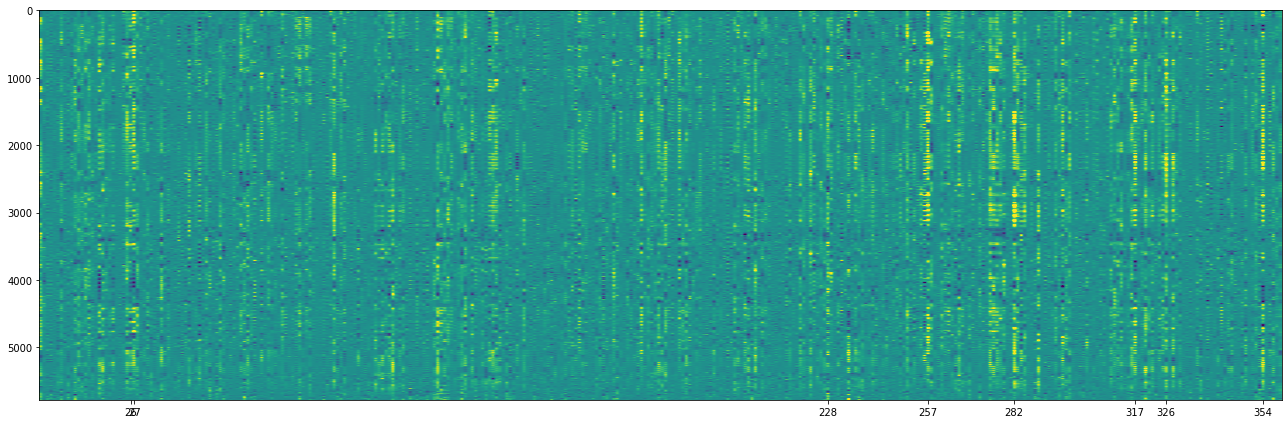

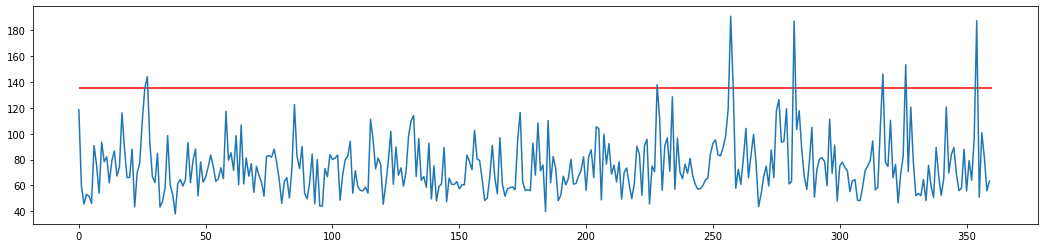

In [61]:
subject=467
B1=Boldwt[str(subject)]
volume=B1.shape[0]
constant_reg=np.arange(108)[np.isnan(stats.zscore(B1))[0,:]]   #Regions where np.var=0 and mess up the edges

B1[:,constant_reg.tolist()]=np.random.normal(size=volume*constant_reg.shape[0]).reshape((volume,constant_reg.shape[0]))
Edges=analysis.go_edge(B1)
eFCD=np.corrcoef(Edges)

p=np.percentile(edges_str(B1),98)
edgec=np.arange(360)[edges_str(B1)>p] 

plt.figure(figsize=(18,6))
plt.imshow(Edges[:,:].T,aspect='auto', cmap='viridis',vmin=-2.5,vmax=2.5)
plt.xticks(edgec)
#plt.colorbar()

plt.tight_layout()

plt.show()
plt.figure(figsize=(18,4))
plt.plot(edges_str(B1))
plt.hlines(p,xmin=0,xmax=360,colors='r')

In [62]:
subject=467

B1=Boldwt[str(subject)]
volume=B1.shape[0]
constant_reg=np.arange(108)[np.isnan(stats.zscore(B1))[0,:]]

B1[:,constant_reg.tolist()]=np.random.normal(size=volume*constant_reg.shape[0]).reshape((volume,constant_reg.shape[0]))
Edges=analysis.go_edge(B1)


# The threshold to binarize our edges -> picked % to the Median absolute value of ALL the edges (can be changed, the factor can be modified, etc) 
threshold=9*np.median(np.abs(Edges))
Edges_bin=np.zeros(shape=Edges.shape)

Edges_bin[np.abs(Edges)>threshold]=1
FCbin=edge_to_FC(np.sum(Edges_bin,0))

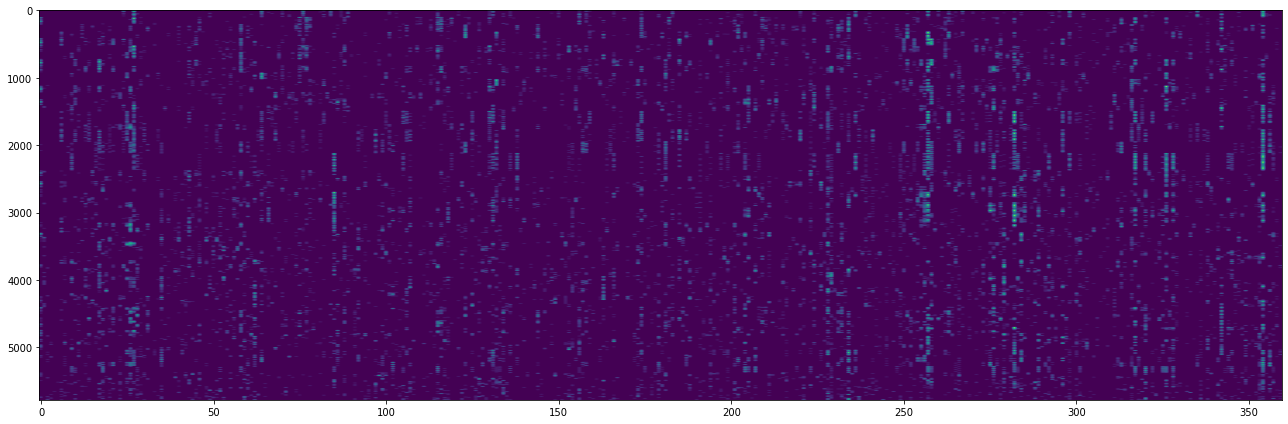

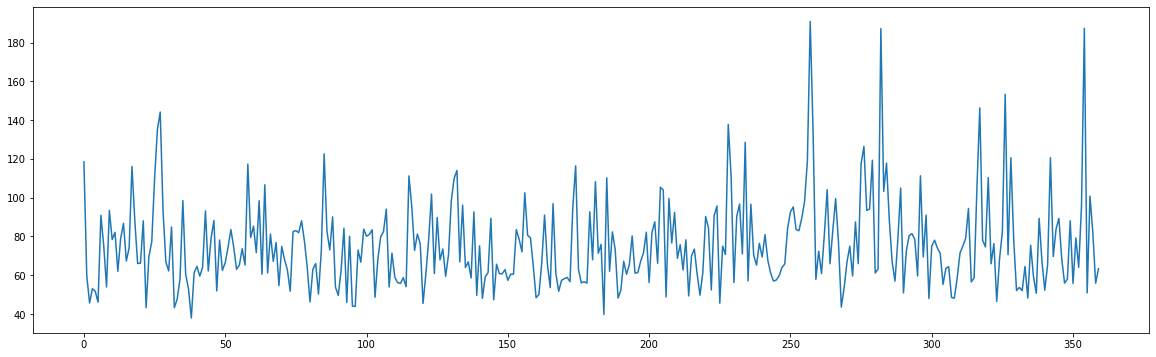

In [80]:
plt.figure(figsize=(18,6))
plt.imshow(Edges_bin[:,:].T,aspect='auto', cmap='viridis',vmin=0,vmax=1)
plt.tight_layout()
plt.show()

plt.figure(figsize=(20,6))
plt.plot(edges_str(B1))
plt.show()

In [89]:
Backbones2=[]
factor=9
delta=1
alpha_list=[5e-2,2.5e-2,1e-2,5e-3,2.5e-3,1e-3,5e-4,2.5e-4,1e-4,5e-5,2.5e-5,1e-5,5e-6,2.5e-6,1e-6,5e-7,2.5e-7,1e-7]
alpha=alpha_list[5]
tau=360
n=108

'''
Code to calculate all the backbones of the dataset in Boldwt dict
Factor is for the threshold
delta and alpha need to be hand picked
tau is the length of the dataset 
n is the number of regions
'''

for subject in Boldwt.keys():
    B1=Boldwt[subject]
    volume=B1.shape[0]
    constant_reg=np.arange(108)[np.isnan(stats.zscore(B1))[0,:]]

    B1[:,constant_reg.tolist()]=np.random.normal(size=volume*constant_reg.shape[0]).reshape((volume,constant_reg.shape[0]))
    Edges=analysis.go_edge(B1)

    threshold=factor*np.median(np.abs(Edges))
    Edges_bin=np.zeros(shape=Edges.shape)

    Edges_bin[np.abs(Edges)>threshold]=1
    Edges_w=window(Edges_bin.T,delta).T

    FCbin=edge_to_FC(np.sum(Edges_w,0))


    b=backbone(FCbin,tau/delta,alpha=alpha)
    Backbones2.append(b)

In [90]:
subjects=list(Boldwt.keys())
ael=[]
jacl=[]

'''
Loop to calculate the correlation between the similarity of the bin edges and the backbone (Jaccard index & number of edges of the backbone active)
with the RSS
'''


for p in range(len(subjects)):

    B1=Boldwt[subjects[p]]
    volume=B1.shape[0]
    constant_reg=np.arange(108)[np.isnan(stats.zscore(B1))[0,:]]

    B1[:,constant_reg.tolist()]=np.random.normal(size=volume*constant_reg.shape[0]).reshape((volume,constant_reg.shape[0]))
    Edges=analysis.go_edge(B1)

    threshold=9*np.median(np.abs(Edges))
    Edges_bin=np.zeros(shape=Edges.shape)

    Edges_bin[np.abs(Edges)>threshold]=1

    back=Backbones2[p]
    Bmat=np.zeros((n,n))
    Bmat[back]=1


    RSS=edges_str(B1)

    active_edges=[]
    jac=[]

    for k in range(volume):
        FCb=edge_to_FC(Edges_bin[k,:])
        Bmatint=FCb+Bmat
        com=np.sum(Bmatint>1)
        active_edges.append(com)
        jac.append(jaccard_index(np.where(FCb==1),back))

    ael.append(stats.pearsonr(active_edges,RSS)[0])
    jacl.append(stats.pearsonr(jac,RSS))

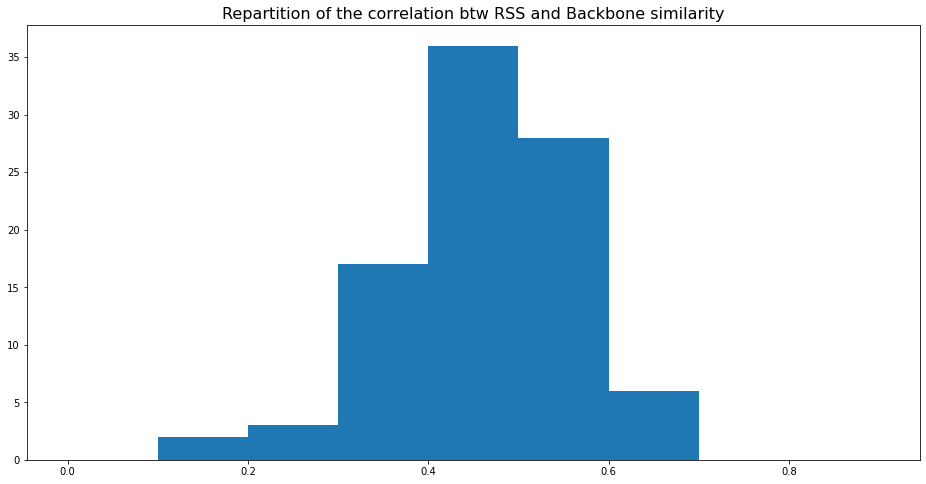

In [91]:
J=np.array(jacl)
plt.figure(figsize=(16,8))
plt.title('Repartition of the correlation btw RSS and Backbone similarity',fontsize=16)
plt.hist(J[:,0],bins=np.arange(0,1,0.1))
plt.show()

(0.32343502348647396, 3.2756963438579334e-10)

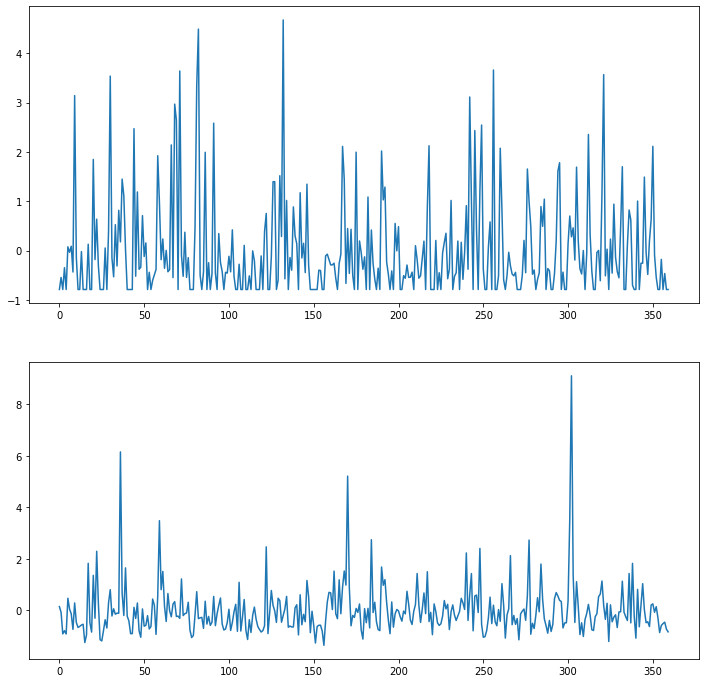

In [38]:
figure=plt.figure(figsize=(12,12))
ax1=figure.add_subplot(211)
jacn=(jac-np.mean(jac))/np.std(jac)
ae=(active_edges-np.mean(active_edges))/np.std(active_edges)
ax1.plot(jacn)

ax2=figure.add_subplot(212)
RSSnorm=(RSS-np.mean(RSS))/np.std(RSS)
ax2.plot(RSSnorm)

stats.pearsonr(jacn,RSSnorm)

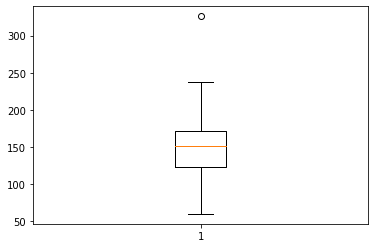

In [36]:
l=len(Backbones2)
b_len=[]

for k in range(len(Backbones2)):
    b_len.append(len(Backbones2[k][0]))

plt.boxplot(b_len)
plt.show()